In [110]:
#imports
import pandas as pd
import seaborn as sn
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, levene, mannwhitneyu, qqplot
from statsmodels.stats.weightstats import ztest as ztest
import matplotlib as plt
# para desenhar os gráficos dentro do notebook
%matplotlib inline

ImportError: cannot import name 'qqplot' from 'scipy.stats' (C:\Users\sonia\anaconda3\envs\SIB\lib\site-packages\scipy\stats\__init__.py)

In [30]:
train = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/train.csv", delimiter=',')
test = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/test.csv", delimiter=',')
updates = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/train_updates_20220929.csv")

In [26]:
train

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [31]:
updates

,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2429,30738,NaN,NaN,NaN,NaN
2430,30739,NaN,NaN,NaN,NaN
2431,30740,NaN,NaN,NaN,NaN
2432,30741,NaN,NaN,NaN,NaN


In [28]:
test

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [32]:
#COPIADO DO CHALLENGE
#columns to update
col_to_update = ['protein_sequence', 'pH', 'tm']
#seq_id to update
to_update_id = list(updates[~updates.protein_sequence.isna()].seq_id)

#reduce updates df to only necessary rows
updates = updates[updates.seq_id.isin(to_update_id)].set_index('seq_id')

#update values on train df
train.loc[to_update_id, col_to_update] = updates[col_to_update].values

#check if updated
pd.concat([train[train.seq_id.isin(to_update_id)].set_index('seq_id'), updates], axis = 1)
train

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [40]:
#obter os descritores - CARINA
#descriptors_df = ProteinDescritors(dataset= train ,  col= 'protein_sequence')
#descriptors_df.dataset
#descriptors_df.get_lenght(n_jobs=4)
#descriptors_df.get_aa_comp(n_jobs=4)
#descriptors_df
#all_descriptors = descriptors_df.get_all_physicochemical(ph=7, amide=False, n_jobs=4)
#all_descriptors
#all_descriptors.to_csv('descriptors.csv')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
dataset = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/descriptors.csv", delimiter=';', header=0)

In [67]:
#verificacao dos data types
data_types = dataset.dtypes
print(data_types)

#sumarização de valores estatísticos gerais
dataset.describe()

Unnamed: 0                                 int64
seq_id                                     int64
protein_sequence                          object
pH                                       float64
length                                   float64
charge                                   float64
chargedensity                            float64
formulaC                                   int64
formulaH                                   int64
formulaN                                   int64
formulaO                                   int64
formulaS                                   int64
tot                                        int64
hydrogen                                   int64
single                                     int64
double                                     int64
MW_modlamp                               float64
Gravy                                    float64
Aromacity                                float64
IsoelectricPoint                         float64
Instability_index   

,Unnamed: 0,seq_id,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,...,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio,tm
count,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,...,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000
mean,14369.000000,15545.248234,6.951551,461.012457,-5.313969,-0.000062,2258.002679,3541.273357,609.005915,711.923240,...,40.477407,0.296239,0.226101,0.267736,48028.957862,48425.448693,85.234561,1.683476,0.370748,49.350659
std,8296.379029,9224.897566,0.951033,430.562526,18.652624,0.000334,2085.418633,3274.813811,568.801797,685.215374,...,11.352726,0.044597,0.043856,0.048460,47705.473385,48142.209405,14.395127,0.551643,0.049421,13.731283
min,0.000000,0.000000,1.990000,5.000000,-903.437000,-0.002708,22.000000,40.000000,8.000000,7.000000,...,-7.383333,0.022727,0.030769,0.000000,0.000000,0.000000,0.000000,-1.661429,0.045977,0.000000
25%,7184.500000,7440.500000,7.000000,219.000000,-9.853500,-0.000232,1086.000000,1700.000000,290.000000,334.000000,...,33.358050,0.274854,0.199166,0.237401,19940.000000,20190.000000,77.061510,1.386256,0.342857,42.300000
50%,14369.000000,15188.000000,7.000000,356.000000,-3.347000,-0.000082,1751.000000,2745.000000,469.000000,541.000000,...,39.665278,0.299758,0.222222,0.265957,35300.000000,35450.000000,85.596817,1.660613,0.372727,48.000000
75%,21553.500000,23694.500000,7.000000,544.000000,3.029000,0.000086,2687.000000,4182.000000,718.000000,833.000000,...,46.754319,0.319873,0.246106,0.293698,60390.000000,61030.000000,94.006806,1.981683,0.399216,53.500000
max,28738.000000,31389.000000,64.900000,8798.000000,396.696000,0.002890,43327.000000,68830.000000,11684.000000,14709.000000,...,141.642748,0.632653,0.747126,0.579832,920160.000000,928160.000000,194.285714,5.281972,0.637681,130.000000


In [68]:
#verificar se há dados omissos
dataset.isnull().sum().sum()
#não há dados omissos

0

In [59]:
#perceber se há colunas com todos os valores iguais (para fazer drop depois) - DÁ ERRO
#nr_cols = len(dataset.axes[1])

#for i in range(nr_cols):
#    column_name = dataset.columns[i]
#    if (dataset[f"{column_name}"] == df[f"{column_name}"][0]).all():
#        print(f"All values are equal in column {column_name}")

KeyError: 'Unnamed: 0'

In [94]:
#eliminar as colunas que só têm todos os valores iguais (neste caso, iguais a zero)
df = dataset.drop(columns=['tot', 'hydrogen', 'single', 'double'], axis=1)

#eliminar linhas duplicadas
df = df.drop_duplicates(subset = "seq_id")

In [81]:
#separar X e Y
X = df.iloc[:, 3:-1]
Y = df.iloc[:, -1]

In [82]:
#visualizar X
X

,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,...,IsoelectricPoint,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio
0,7.0,341.0,-1.732,-0.000048,1622,2623,447,473,9,36319.84,...,6.109589,28.389736,0.316716,0.211144,0.351906,26470,26470,102.991202,1.020440,0.454545
1,7.0,286.0,-12.537,-0.000382,1385,2224,412,490,2,32837.09,...,5.144349,65.108392,0.213287,0.160839,0.367133,20970,20970,72.062937,3.240490,0.297203
2,7.0,497.0,11.513,0.000215,2290,3559,669,760,15,53428.00,...,9.032101,35.089336,0.209256,0.267606,0.213280,40340,40840,54.245473,2.168934,0.301811
3,7.0,265.0,-20.606,-0.000699,1293,2006,338,428,7,29474.71,...,4.683840,50.502264,0.267925,0.215094,0.298113,22460,22710,78.792453,1.902415,0.343396
4,7.0,1451.0,-21.900,-0.000138,6948,10869,1869,2252,45,158761.55,...,5.917928,45.668808,0.271537,0.292901,0.206065,158030,158905,77.746382,1.684390,0.318401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28734,7.0,549.0,5.709,0.000092,2710,4196,774,829,25,61996.83,...,8.466327,48.604026,0.287796,0.242259,0.224044,98320,99070,75.792350,2.063898,0.336976
28735,7.0,469.0,-3.132,-0.000060,2342,3642,632,698,19,52636.87,...,6.532244,35.285096,0.324094,0.217484,0.270789,48360,48610,92.942431,1.389019,0.402985
28736,7.0,128.0,-2.866,-0.000202,626,936,158,198,8,14202.99,...,5.271214,44.198437,0.265625,0.250000,0.257812,27960,27960,62.578125,1.293672,0.367188
28737,7.0,593.0,-9.209,-0.000143,2832,4477,753,884,31,64367.10,...,5.688128,36.618398,0.288364,0.268128,0.259696,43320,43570,83.355818,1.334250,0.384486


In [83]:
#visualizar y
Y

0        75.7
1        50.5
2        40.5
3        47.2
4        49.5
         ... 
28734    51.8
28735    37.2
28736    64.6
28737    50.7
28738    37.6
Name: tm, Length: 28739, dtype: float64

In [ ]:
#testar normalidade dos dados shapiro - COMO FAZER? DEU SEMPRE ERRO

In [101]:
#fazer normalização dos dados
scaler_st = StandardScaler().fit(X)
data_st = scaler_st.transform(X)

#sumariar os dados transformados (atenção que agora é array numpy e não panda dataframe)
np.set_printoptions(precision = 3)
print(data_st[0:5,:])

#converter de novo a panda dataframe
data_scale_X =  pd.DataFrame(data_st, index =X.index , columns = X.columns)
data_scale_X

[[ 5.094e-02 -2.787e-01  1.920e-01  4.171e-02 -3.050e-01 -2.804e-01
  -2.848e-01 -3.487e-01 -4.586e-01 -3.144e-01  1.496e+00 -8.642e-01
  -3.805e-01 -1.065e+00  4.591e-01 -3.411e-01  1.737e+00 -4.519e-01
  -4.561e-01  1.234e+00 -1.202e+00  1.696e+00]
 [ 5.094e-02 -4.065e-01 -3.872e-01 -9.577e-01 -4.186e-01 -4.023e-01
  -3.464e-01 -3.239e-01 -8.379e-01 -3.869e-01 -2.383e+00 -1.524e+00
  -9.509e-01  2.170e+00 -1.860e+00 -1.488e+00  2.051e+00 -5.672e-01
  -5.703e-01 -9.150e-01  2.823e+00 -1.488e+00]
 [ 5.094e-02  8.358e-02  9.021e-01  8.289e-01  1.534e-02  5.413e-03
   1.055e-01  7.016e-02 -1.335e-01  4.150e-02 -1.195e+00 -1.893e-03
   1.347e+00 -4.746e-01 -1.950e+00  9.464e-01 -1.124e+00 -1.612e-01
  -1.576e-01 -2.153e+00  8.800e-01 -1.395e+00]
 [ 5.094e-02 -4.553e-01 -8.198e-01 -1.907e+00 -4.627e-01 -4.688e-01
  -4.765e-01 -4.144e-01 -5.670e-01 -4.569e-01 -5.599e-01 -3.489e-01
  -1.223e+00  8.831e-01 -6.349e-01 -2.510e-01  6.269e-01 -5.360e-01
  -5.342e-01 -4.475e-01  3.969e-01 -5.535e-

,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,...,IsoelectricPoint,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio
0,0.050944,-0.278739,0.192039,0.041713,-0.304981,-0.280410,-0.284825,-0.348689,-0.458594,-0.314437,...,-0.380486,-1.064756,0.459141,-0.341062,1.736920,-0.451926,-0.456062,1.233539,-1.201951,1.695606
1,0.050944,-0.406481,-0.387246,-0.957675,-0.418630,-0.402251,-0.346359,-0.323879,-0.837876,-0.386896,...,-0.950904,2.169647,-1.860071,-1.488109,2.051137,-0.567219,-0.570309,-0.915022,2.822551,-1.488163
2,0.050944,0.083584,0.902139,0.828932,0.015344,0.005413,0.105476,0.070164,-0.133496,0.041500,...,1.346604,-0.474614,-1.950464,0.946386,-1.123765,-0.161178,-0.157566,-2.152786,0.880036,-1.394920
3,0.050944,-0.455255,-0.819847,-1.906825,-0.462746,-0.468821,-0.476459,-0.414363,-0.566960,-0.456850,...,-1.223047,0.883051,-0.634913,-0.250979,0.626853,-0.535985,-0.534165,-0.447528,0.396892,-0.553456
4,0.050944,2.299329,-0.889222,-0.228271,2.248987,2.237640,2.215211,2.247620,1.491996,2.232975,...,-0.493750,0.457290,-0.553913,1.523183,-1.272651,2.305877,2.294898,-0.520198,0.001656,-1.059223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28734,0.050944,0.204358,0.590971,0.459809,0.216746,0.199931,0.290078,0.170864,0.408335,0.219776,...,1.012253,0.715842,-0.189330,0.368423,-0.901639,1.054217,1.051996,-0.655943,0.689628,-0.683361
28735,0.050944,0.018552,0.116981,0.006371,0.040279,0.030759,0.040426,-0.020320,0.083236,0.025041,...,-0.130713,-0.457370,0.624586,-0.196490,0.062991,0.006939,0.003834,0.535459,-0.533792,0.652301
28736,0.050944,-0.773449,0.131242,-0.419214,-0.782592,-0.795562,-0.792919,-0.750030,-0.512777,-0.774580,...,-0.875932,0.327771,-0.686476,0.544941,-0.204789,-0.420692,-0.425111,-1.573924,-0.706637,-0.072049
28737,0.050944,0.306552,-0.208823,-0.243604,0.275248,0.285739,0.253158,0.251132,0.733433,0.269089,...,-0.629552,-0.339925,-0.176588,0.958301,-0.165912,-0.098711,-0.100858,-0.130515,-0.633078,0.277973


In [89]:
#será mesmo preciso esta linha de codigo que está sempre nos exercicios dos profs? já normalizamos antes supostamente
#data_scale = preprocessing.scale(iris.iloc[:,:4])

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

AttributeError: module 'matplotlib' has no attribute 'show'

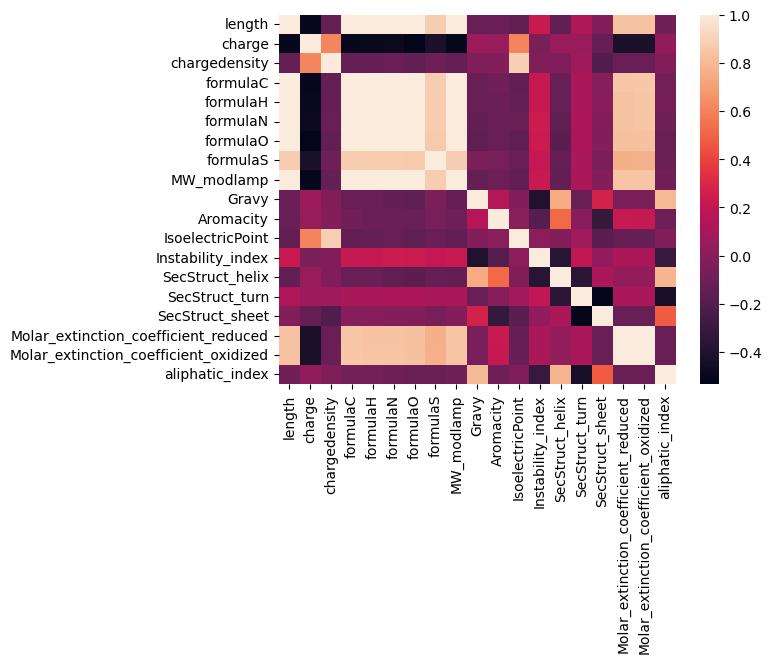

In [111]:
#correlação entre variáveis
corr_matrix = data_scale_X.corr()
corr_matrix

#heatmat de correlações entre variáveis - INTERPRETAR
sn.heatmap(corr_matrix.iloc[1:20,1:20], annot=False)
#plt.show()


In [112]:
#boxplots para cada variável continua - TPC
#o objetivo é perceber se os valores são parecidos, se há outliers etc
#depois da reunião, a angelina escreveu isto (não percebemos)
#aplicar o package pip install git+https://github.com/jcapels/propythia.git@fix_dependencies para obter descritores fisico-químicos -> para correlações, etc. se valores fora de gama para os modelos (no random forest não é importante, mas modelos lineares é) usar sealers

matplotlib.pyplot.boxplot(data_scale_X, notch=None, vert=None, patch_artist=None, widths=None)
#plt.xticks([1,2,3],labels)
#plt.title(" Boxplot")
#plt.show()


NameError: name 'matplotlib' is not defined

In [ ]:
#qqplots para verificar visualmente a normalidade - TPC
#o shapiro analisa quantitativamente a normalidade, mas deu erro
#o ideal era ter as duas formas
qqplot(data_st, dist=stats.norm, distargs=(),a=0, loc=0, scale=1,
fit=False,line=False, ax=None)

In [ ]:
#analisar os valores de tm (o nosso Y), de forma a criar adicionalmente uma variável categórica com os valores (tm baixo / tm alto)


